# Прогнозирование принадлежности района к кластеру с использованием метода К ближайших соседей   
## (в развитие [этой](https://github.com/s-eremeev/eremeev/blob/eremeev/test_project_Califitnia/test_project.ipynb) работы)

In [1]:
#!pip install sqlalchemy

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure # размеры графика
from sklearn.preprocessing import StandardScaler # стандартизация данных
from sklearn.model_selection import train_test_split # разделение на обучающую и тестовую выборки
from sklearn.neighbors import KNeighborsClassifier # модуль К ближайших
from sklearn.metrics import classification_report # оценка точности ?
from sklearn.metrics import confusion_matrix # оценка точности ?

**neighborhoods** - случайная выборка районов штата Калифорния. Каждая строка таблицы представляет собой какой-то район, имеющий такие атрибуты, как:

    - id - уникальный идентификатор, primary key;
    - longitude - географическая долгота, град.;
    - latitude - географическая широта, град.;
    - median_house_value - медианная стоимость жилого дома в данном районе, доллар США;
    - population - численность населения района, чел.;
    - ocean_proximity - кластер по принципу близости к океану, качественная переменная;
    
#### Для некоторых районов принадлежность к кластеру не указана, её, собственно, и нужно спрогнозировать.

In [3]:
#установление соединения с БД
engine = create_engine('sqlite:///test_project.db')
# загрузим neighborhoods в df
sql = 'select * from neighborhoods n;'
df_neighborhoods = pd.read_sql(sql, engine)
df_neighborhoods.head()

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY


In [4]:
# разделим df_neighborhoods на два df: df_neighborhoods_ocean_proximity, где ocean_proximity значим, и df_neighborhoods_no_ocean_proximity, где он None
df_neighborhoods_ocean_proximity = df_neighborhoods[df_neighborhoods['ocean_proximity'].notna()]
df_neighborhoods_no_ocean_proximity = df_neighborhoods[df_neighborhoods['ocean_proximity'].isna()]
# сохраним копию df_neighborhoods_no_ocean_proximity с категориальными значениями в ocean_proximity для некоторых дальнейших манипуляций 
df_neighborhoods_ploy = df_neighborhoods_ocean_proximity

In [5]:
# заменим номинативные переменные числовыми для простроения модели линейной регрессии
df_neighborhoods_ocean_proximity = df_neighborhoods_ocean_proximity.replace({'ocean_proximity': {'NEAR BAY': 1, '<1H OCEAN': 2, 'INLAND': 3, 'NEAR OCEAN': 4, 'ISLAND': 5}})

In [6]:
df_neighborhoods_ocean_proximity

,id,longitude,latitude,median_house_value,population,ocean_proximity
1,1,-122.22,37.86,358500.0,2401.0,1
2,2,-122.24,37.85,352100.0,496.0,1
4,4,-122.25,37.85,342200.0,565.0,1
5,5,-122.25,37.85,269700.0,413.0,1
8,8,-122.26,37.84,226700.0,1206.0,1
...,...,...,...,...,...,...
16207,16207,-121.56,39.27,116800.0,1041.0,3
16208,16208,-121.09,39.48,78100.0,845.0,3
16209,16209,-121.21,39.49,77100.0,356.0,3
16210,16210,-121.22,39.43,92300.0,1007.0,3


### Стандартизация данных

In [7]:
scaler = StandardScaler()
scaler.fit(df_neighborhoods_ocean_proximity.drop(['id', 'ocean_proximity'], axis=1))
scaled_features = scaler.transform(df_neighborhoods_ocean_proximity.drop(['id', 'ocean_proximity'], axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = df_neighborhoods_ocean_proximity.drop(['id', 'ocean_proximity'], axis=1).columns)

In [8]:
scaled_data

,longitude,latitude,median_house_value,population
0,-1.326645,1.053660,1.316666,0.835201
1,-1.336624,1.048956,1.261102,-0.796680
2,-1.341614,1.048956,1.175151,-0.737573
3,-1.341614,1.048956,0.545715,-0.867781
4,-1.346603,1.044253,0.172394,-0.188473
...,...,...,...,...
11195,-0.997331,1.716835,-0.781745,-0.329817
11196,-0.762819,1.815605,-1.117733,-0.497716
11197,-0.822695,1.820309,-1.126415,-0.916608
11198,-0.827684,1.792089,-0.994451,-0.358942


### Разделение на обучающую и тестовую выбоки

In [9]:
x = scaled_data
y = df_neighborhoods_ocean_proximity['ocean_proximity']
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.2)

### Обучение модели K-ближайших соседей (для начала n_neighbors = 1)

In [10]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(x_training_data, y_training_data)

KNeighborsClassifier(n_neighbors=1)

### Прогноз и оценка точности

In [11]:
pd.options.mode.chained_assignment = None # чтобы не предупреждал
predictions = model.predict(x_test_data)
# этого я не понимаю
print('classification_report =\n', classification_report(y_test_data, predictions))
print('confusion_matrix =\n', confusion_matrix(y_test_data, predictions))

classification_report =
               precision    recall  f1-score   support

           1       0.77      0.79      0.78       246
           2       0.87      0.91      0.89      1019
           3       0.95      0.90      0.93       699
           4       0.67      0.63      0.65       275
           5       0.00      0.00      0.00         1

    accuracy                           0.86      2240
   macro avg       0.65      0.65      0.65      2240
weighted avg       0.86      0.86      0.86      2240

confusion_matrix =
 [[194  15   8  29   0]
 [ 16 925  23  55   0]
 [ 15  52 631   1   0]
 [ 26  74   1 174   0]
 [  0   1   0   0   0]]


/home/sk27/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sk27/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sk27/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

**Выбор оптимального значения для K с помощью метода «Локтя»**

В этом разделе мы будем использовать метод «локтя», чтобы выбрать оптимальное значение K для нашего алгоритма K-ближайших соседей.

Метод локтя включает в себя итерацию по различным значениям K и выбор значения с наименьшей частотой ошибок при применении к нашим тестовым данным.

1. Для начала создадим пустой список error_rates. Мы пройдемся по различным значениям K и добавим их частоту ошибок в этот список.   
2. Затем нам нужно создать цикл Python, который перебирает различные значения K, которые мы хотим протестировать, и на каждой итерации выполняет следующее:
* Создает новый экземпляр класса KNeighborsClassifier из scikit-learn.
* Тренирует эту модель, используя наши обучающие данные.
* Делает прогнозы на основе наших тестовых данных.
* Вычисляет долю неверных предсказаний (чем она ниже, тем точнее наша модель).   

(2) Реализация описанного цикла для значений K от 1 до 100:

3. Давайте визуализируем, как изменяется частота ошибок при различных K, используя matplotlib — plt.plot(error_rates):

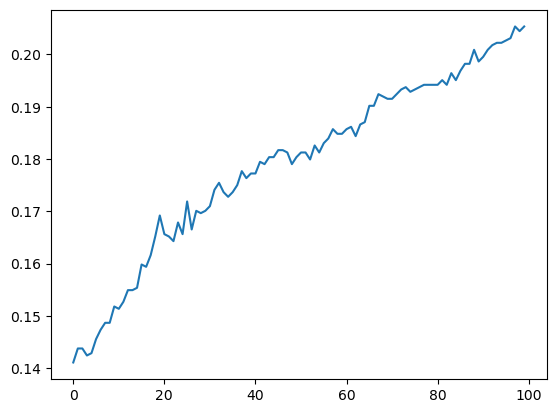

In [12]:
# 1.
error_rates = []
# 2.
for i in np.arange(1, 101):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(np.mean(new_predictions != y_test_data))
# 3.
plt.plot(error_rates);

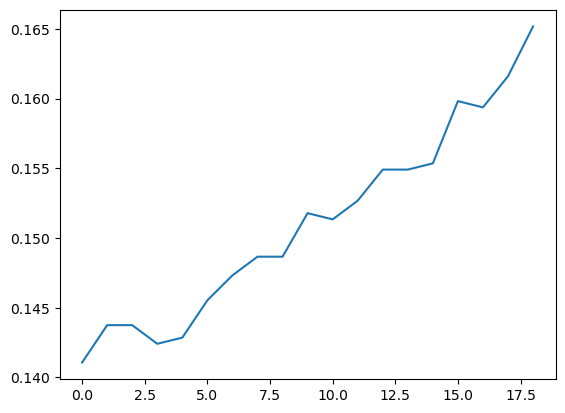

In [14]:
# достаточно интервала (1, 5)
# 1.
error_rates = []
# 2.
for i in np.arange(1, 20):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(np.mean(new_predictions != y_test_data))
# 3.
plt.plot(error_rates);

К = 2

### Обучение модели K-ближайших соседей (n_neighbors = 2)

In [49]:
model = KNeighborsClassifier(n_neighbors = 2)
model.fit(x_training_data, y_training_data)

KNeighborsClassifier(n_neighbors=2)

### Прогноз

In [100]:
# используем часть данных, для которых кластер не определён
df_neighborhoods_no_ocean_proximity

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
3,3,-122.25,37.85,341300.0,558.0,None
6,6,-122.25,37.84,299200.0,1094.0,None
7,7,-122.25,37.84,241400.0,1157.0,None
9,9,-122.25,37.84,261100.0,1551.0,None
...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,None
16201,16201,-121.52,39.12,72000.0,29.0,None
16203,16203,-121.32,39.13,162500.0,169.0,None
16204,16204,-121.48,39.10,92400.0,1018.0,None


In [101]:
# стандиртизируем данные
scaler = StandardScaler()
scaler.fit(df_neighborhoods_no_ocean_proximity.drop(['id', 'ocean_proximity'], axis=1))
scaled_features = scaler.transform(df_neighborhoods_no_ocean_proximity.drop(['id', 'ocean_proximity'], axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = df_neighborhoods_no_ocean_proximity.drop(['id', 'ocean_proximity'], axis=1).columns)
scaled_data

,longitude,latitude,median_house_value,population
0,-1.333560,1.046531,2.101035,-0.987190
1,-1.343582,1.032540,1.141754,-0.778652
2,-1.343582,1.027876,0.778899,-0.305024
3,-1.343582,1.027876,0.280728,-0.249355
4,-1.343582,1.027876,0.450520,0.098797
...,...,...,...,...
5008,-0.957764,1.592179,-0.937981,-1.138291
5009,-0.977807,1.624824,-1.179310,-1.246095
5010,-0.877594,1.629488,-0.399301,-1.122386
5011,-0.957764,1.615497,-1.003484,-0.372180


In [102]:
df_neighborhoods_no_ocean_proximity

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
3,3,-122.25,37.85,341300.0,558.0,None
6,6,-122.25,37.84,299200.0,1094.0,None
7,7,-122.25,37.84,241400.0,1157.0,None
9,9,-122.25,37.84,261100.0,1551.0,None
...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,None
16201,16201,-121.52,39.12,72000.0,29.0,None
16203,16203,-121.32,39.13,162500.0,169.0,None
16204,16204,-121.48,39.10,92400.0,1018.0,None


In [103]:
pd.options.mode.chained_assignment = None # чтобы не предупреждал
df_neighborhoods_no_ocean_proximity['predict_cluster'] = model.predict(scaled_data)
df_neighborhoods_no_ocean_proximity

,id,longitude,latitude,median_house_value,population,ocean_proximity,predict_cluster
0,0,-122.23,37.88,452600.0,322.0,None,1
3,3,-122.25,37.85,341300.0,558.0,None,1
6,6,-122.25,37.84,299200.0,1094.0,None,1
7,7,-122.25,37.84,241400.0,1157.0,None,1
9,9,-122.25,37.84,261100.0,1551.0,None,1
...,...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,None,3
16201,16201,-121.52,39.12,72000.0,29.0,None,3
16203,16203,-121.32,39.13,162500.0,169.0,None,3
16204,16204,-121.48,39.10,92400.0,1018.0,None,3


In [104]:
df_neighborhoods_no_ocean_proximity = df_neighborhoods_no_ocean_proximity.drop(['ocean_proximity'], axis = 1)
# df_neighborhoods_no_ocean_proximity = df_neighborhoods_no_ocean_proximity.rename(columns={'predict_cluster': 'ocean_proximity'}, inplace=True)

In [105]:
# df_neighborhoods_no_ocean_proximity = df_neighborhoods_no_ocean_proximity.rename(columns={'predict_cluster': 'ocean_proximity'}, inplace=True)
df_neighborhoods_no_ocean_proximity

,id,longitude,latitude,median_house_value,population,predict_cluster
0,0,-122.23,37.88,452600.0,322.0,1
3,3,-122.25,37.85,341300.0,558.0,1
6,6,-122.25,37.84,299200.0,1094.0,1
7,7,-122.25,37.84,241400.0,1157.0,1
9,9,-122.25,37.84,261100.0,1551.0,1
...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,3
16201,16201,-121.52,39.12,72000.0,29.0,3
16203,16203,-121.32,39.13,162500.0,169.0,3
16204,16204,-121.48,39.10,92400.0,1018.0,3


In [106]:
df_neighborhoods_ocean_proximity_predict = df_neighborhoods_no_ocean_proximity.rename(columns={'predict_cluster': 'ocean_proximity'})

In [107]:
df_neighborhoods_ocean_proximity_predict

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,1
3,3,-122.25,37.85,341300.0,558.0,1
6,6,-122.25,37.84,299200.0,1094.0,1
7,7,-122.25,37.84,241400.0,1157.0,1
9,9,-122.25,37.84,261100.0,1551.0,1
...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,3
16201,16201,-121.52,39.12,72000.0,29.0,3
16203,16203,-121.32,39.13,162500.0,169.0,3
16204,16204,-121.48,39.10,92400.0,1018.0,3


In [111]:
# соединим разделённые ранее таблицы обратно
df_neighborhoods_full = pd.concat([df_neighborhoods_ocean_proximity, df_neighborhoods_ocean_proximity_predict])
df_neighborhoods_full

,id,longitude,latitude,median_house_value,population,ocean_proximity
1,1,-122.22,37.86,358500.0,2401.0,1
2,2,-122.24,37.85,352100.0,496.0,1
4,4,-122.25,37.85,342200.0,565.0,1
5,5,-122.25,37.85,269700.0,413.0,1
8,8,-122.26,37.84,226700.0,1206.0,1
...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,3
16201,16201,-121.52,39.12,72000.0,29.0,3
16203,16203,-121.32,39.13,162500.0,169.0,3
16204,16204,-121.48,39.10,92400.0,1018.0,3


In [112]:
df_neighborhoods_full.groupby('ocean_proximity').count()

,id,longitude,latitude,median_house_value,population
ocean_proximity,,,,,
1,1959,1959,1959,1959,1959
2,7475,7475,7475,7475,7475
3,4962,4962,4962,4962,4962
4,1815,1815,1815,1815,1815
5,2,2,2,2,2


In [114]:
# возвратим кластерам их исторические имена
df_neighborhoods_full = df_neighborhoods_full.replace({'ocean_proximity': {1: 'NEAR BAY', 2: '<1H OCEAN', 3: 'INLAND', 4: 'NEAR OCEAN', 5: 'ISLAND'}})
df_neighborhoods_full = df_neighborhoods_full.sort_values('id')

In [116]:
# готово!
df_neighborhoods_full

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,NEAR BAY
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,NEAR BAY
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,INLAND


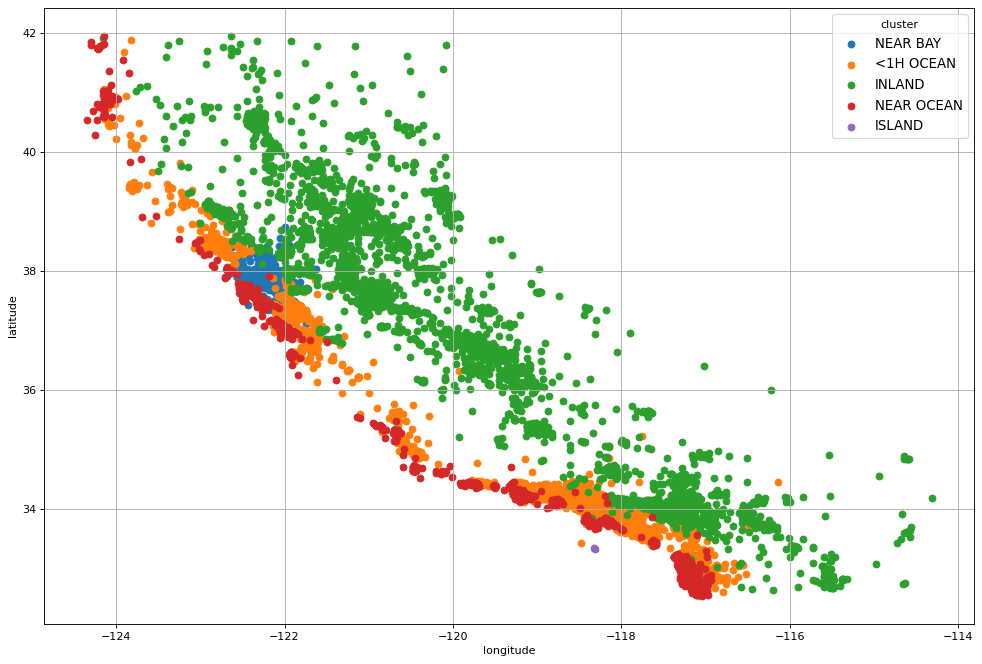

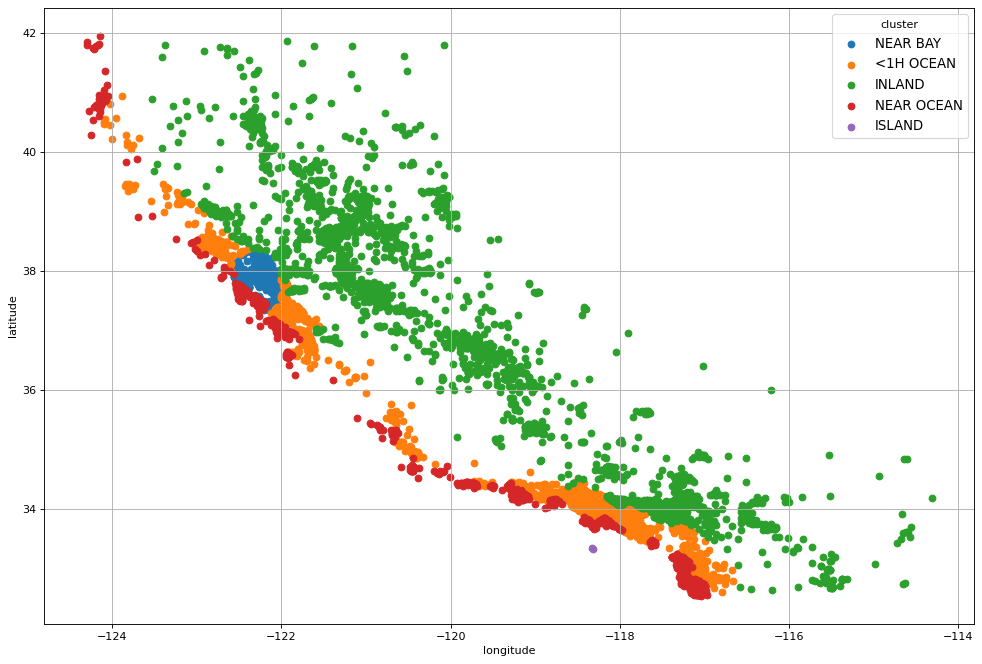

In [159]:
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)


# сравним расположение районов "на местности"
cluster_list = ['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
for cluster in cluster_list:
    # выберем значения, соответствующие кластеру из списка
    subset = df_neighborhoods_full[df_neighborhoods_full.ocean_proximity == cluster]
    
    plt.scatter(subset.longitude, subset.latitude, label = cluster);
    plt.grid(True)
    
plt.legend(prop={'size': 12}, title = 'cluster')
plt.xlabel('longitude')
plt.ylabel('latitude');

# а так было:
figure(figsize=(15, 10), dpi=80)
cluster_list = ['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
for cluster in cluster_list:
    # выберем значения, соответствующие кластеру из списка
    subset = df_neighborhoods_ploy[df_neighborhoods_ploy.ocean_proximity == cluster]
    
    plt.scatter(subset.longitude, subset.latitude, label = cluster);
    plt.grid(True)
    
plt.legend(prop={'size': 12}, title = 'cluster')
plt.xlabel('longitude')
plt.ylabel('latitude');